Import Libraries and Load Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("-"*60)

# Load and preprocess data (same as before)
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('../data/train_FD001.txt', 
                       sep=' ', 
                       header=None, 
                       names=column_names,
                       index_col=False)

train_df = train_df.dropna(axis=1, how='all')

# Calculate RUL
max_cycles = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_cycles']

# Remove low-variance sensors
low_variance_sensors = ['sensor_1', 'sensor_5', 'sensor_6', 
                        'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_df = train_df.drop(columns=low_variance_sensors)

# Scale features
sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
setting_cols = ['setting_1', 'setting_2', 'setting_3']
features_to_scale = sensor_cols + setting_cols

scaler = MinMaxScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

print(f"✓ Data loaded and preprocessed")
print(f"  Total samples: {len(train_df):,}")
print(f"  Features: {len(features_to_scale)}")
print(f"  Target: RUL (range 0-{train_df['RUL'].max()})")

✓ Libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.12.0
------------------------------------------------------------
✓ Data loaded and preprocessed
  Total samples: 20,631
  Features: 17
  Target: RUL (range 0-361)


Create Time-Series Sequences for LSTM

------------------------------------------------------------
CREATING TIME-SERIES SEQUENCES FOR LSTM
------------------------------------------------------------

Sequence length: 30 cycles
This means: LSTM will look at the last 30 measurements to predict RUL

Creating sequences...

Sequences created!
Shape of X: (17731, 30, 17)
  - 17,731 sequences
  - 30 time steps per sequence
  - 17 features per time step
Shape of y: (17731,)

------------------------------------------------------------
TRAIN/TEST SPLIT
------------------------------------------------------------
Training sequences: 14,184 (80.0%)
Test sequences: 3,547 (20.0%)

------------------------------------------------------------
EXAMPLE SEQUENCE
------------------------------------------------------------
First sequence shape: (30, 17)
Target RUL for this sequence: 29 cycles


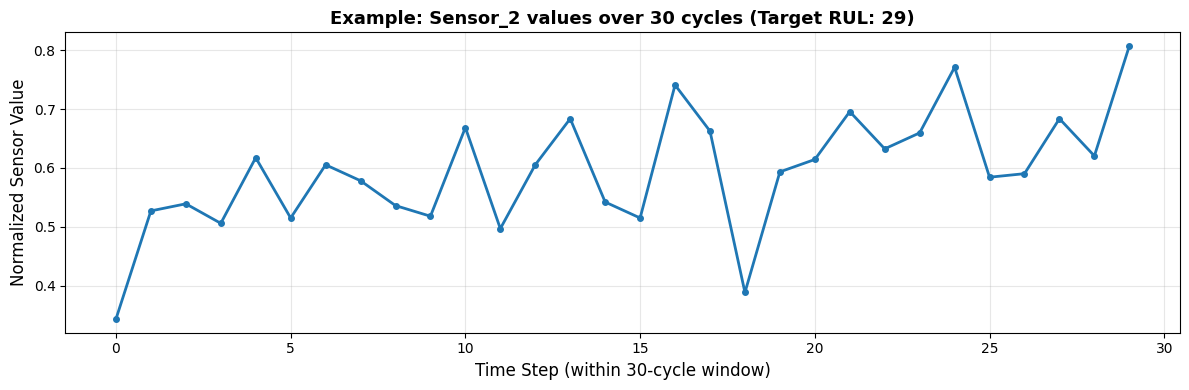


Data prepared for LSTM training


In [2]:
print("-"*60)
print("CREATING TIME-SERIES SEQUENCES FOR LSTM")
print("-"*60)

# Sequence length (how many time steps to look back)
sequence_length = 30  # Use last 30 cycles to predict RUL

print(f"\nSequence length: {sequence_length} cycles")
print("This means: LSTM will look at the last 30 measurements to predict RUL")

def create_sequences(df, seq_length, features):
    """
    Create sequences for LSTM training
    
    For each engine, create overlapping sequences of length seq_length
    Example: If engine has 100 cycles, create sequences:
      - Cycles 0-29 → predict RUL at cycle 29
      - Cycles 1-30 → predict RUL at cycle 30
      - ... and so on
    """
    sequences = []
    targets = []
    
    # Process each engine separately
    for unit in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == unit]
        
        # Get feature values and RUL
        feature_values = engine_data[features].values
        rul_values = engine_data['RUL'].values
        
        # Create sequences
        for i in range(len(engine_data) - seq_length + 1):
            seq = feature_values[i:i + seq_length]
            target = rul_values[i + seq_length - 1]  # RUL at end of sequence
            
            sequences.append(seq)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

# Create sequences
print("\nCreating sequences...")
X_seq, y_seq = create_sequences(train_df, sequence_length, features_to_scale)

print(f"\nSequences created!")
print(f"Shape of X: {X_seq.shape}")
print(f"  - {X_seq.shape[0]:,} sequences")
print(f"  - {X_seq.shape[1]} time steps per sequence")
print(f"  - {X_seq.shape[2]} features per time step")
print(f"Shape of y: {y_seq.shape}")

# Split into train/test
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

print("\n" + "-"*60)
print("TRAIN/TEST SPLIT")
print("-"*60)
print(f"Training sequences: {len(X_train_seq):,} ({len(X_train_seq)/len(X_seq)*100:.1f}%)")
print(f"Test sequences: {len(X_test_seq):,} ({len(X_test_seq)/len(X_seq)*100:.1f}%)")

# Visualize one sequence
print("\n" + "-"*60)
print("EXAMPLE SEQUENCE")
print("-"*60)
print(f"First sequence shape: {X_train_seq[0].shape}")
print(f"Target RUL for this sequence: {y_train_seq[0]:.0f} cycles")

# Plot one feature across the sequence
plt.figure(figsize=(12, 4))
plt.plot(X_train_seq[0][:, 0], marker='o', linewidth=2, markersize=4)  # Plot first feature (sensor_2)
plt.xlabel('Time Step (within 30-cycle window)', fontsize=12)
plt.ylabel('Normalized Sensor Value', fontsize=12)
plt.title(f'Example: Sensor_2 values over 30 cycles (Target RUL: {y_train_seq[0]:.0f})', 
          fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nData prepared for LSTM training")

Build LSTM Model Architecture

In [3]:
print("-"*60)
print("BUILDING LSTM NEURAL NETWORK")
print("-"*60)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build LSTM model
model = Sequential([
    # First LSTM layer
    LSTM(units=64, return_sequences=True, input_shape=(sequence_length, len(features_to_scale))),
    Dropout(0.2),  # Dropout to prevent overfitting
    
    # Second LSTM layer
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    
    # Dense layers
    Dense(units=16, activation='relu'),
    Dropout(0.1),
    
    # Output layer
    Dense(units=1)  # Single output: RUL prediction
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

print("\nModel architecture created!")

# Display model summary
print("\n" + "-"*60)
print("MODEL ARCHITECTURE")
print("-"*60)
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

# Visualize architecture
print("\n" + "-"*60)
print("LAYER EXPLANATION")
print("-"*60)
print("""
Layer 1 (LSTM-64): 
  - 64 LSTM units with memory
  - Learns temporal patterns from 30 time steps
  - return_sequences=True passes output to next LSTM

Layer 2 (Dropout-0.2):
  - Randomly drops 20% of connections during training
  - Prevents overfitting

Layer 3 (LSTM-32):
  - 32 LSTM units for higher-level patterns
  - return_sequences=False outputs single vector

Layer 4 (Dropout-0.2):
  - Another 20% dropout for regularization

Layer 5 (Dense-16):
  - Fully connected layer with 16 neurons
  - ReLU activation for non-linearity

Layer 6 (Dropout-0.1):
  - Light 10% dropout

Layer 7 (Dense-1):
  - Output layer
  - Single neuron for RUL prediction
""")

------------------------------------------------------------
BUILDING LSTM NEURAL NETWORK
------------------------------------------------------------

Model architecture created!

------------------------------------------------------------
MODEL ARCHITECTURE
------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 33,953

------------------------------------------------------------
LAYER EXPLANATION
------------------------------------------------------------

Layer 1 (LSTM-64): 
  - 64 LSTM units with memory
  - Learns temporal patterns from 30 time steps
  - return_sequences=True passes output to next LSTM

Layer 2 (Dropout-0.2):
  - Randomly drops 20% of connections during training
  - Prevents overfitting

Layer 3 (LSTM-32):
  - 32 LSTM units for higher-level patterns
  - return_sequences=False outputs single vector

Layer 4 (Dropout-0.2):
  - Another 20% dropout for regularization

Layer 5 (Dense-16):
  - Fully connected layer with 16 neurons
  - ReLU activation for non-linearity

Layer 6 (Dropout-0.1):
  - Light 10% dropout

Layer 7 (Dense-1):
  - Output layer
  - Single neuron for RUL prediction



Train the LSTM Model

------------------------------------------------------------
TRAINING LSTM MODEL
------------------------------------------------------------

Callbacks configured:
  - Early Stopping: Stops if validation loss doesn't improve for 15 epochs
  - Learning Rate Reduction: Reduces learning rate if stuck

Starting training...
Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 9614.4902 - mae: 78.0669 - val_loss: 6757.7271 - val_mae: 63.3787 - learning_rate: 0.0010
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 5128.8501 - mae: 55.5764 - val_loss: 3987.3240 - val_mae: 50.5602 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 4029.1343 - mae: 51.2606 - val_loss: 3831.1343 - val_mae: 50.3111 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4008.9624 - mae: 51.3659 - val_loss: 3830.0771 - val_mae: 50.3401 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4020.939

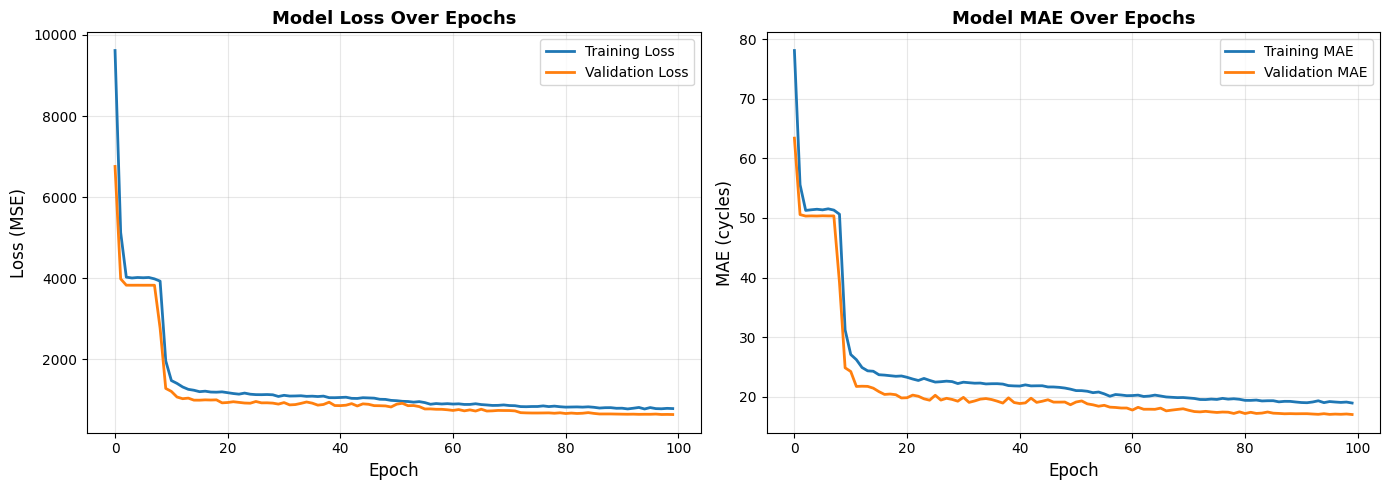


Total epochs trained: 100
Best validation loss: 643.71
Best validation MAE: 17.04 cycles


In [4]:
print("-"*60)
print("TRAINING LSTM MODEL")
print("-"*60)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

print("\nCallbacks configured:")
print("  - Early Stopping: Stops if validation loss doesn't improve for 15 epochs")
print("  - Learning Rate Reduction: Reduces learning rate if stuck")

print("\nStarting training...")

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "-"*60)
print("TRAINING COMPLETE!")
print("-"*60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (cycles)', fontsize=12)
axes[1].set_title('Model MAE Over Epochs', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal epochs trained: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.2f}")
print(f"Best validation MAE: {min(history.history['val_mae']):.2f} cycles")

Evaluate LSTM Model

------------------------------------------------------------
EVALUATING LSTM MODEL ON TEST SET
------------------------------------------------------------

Making predictions on test set...

------------------------------------------------------------
LSTM PERFORMANCE METRICS
------------------------------------------------------------

Test Set:
  RMSE: 25.00 cycles
  MAE:  16.92 cycles
  R²:   0.8366

------------------------------------------------------------
COMPARISON: LSTM vs RANDOM FOREST
------------------------------------------------------------

Metric     LSTM         Random Forest   Improvement
------------------------------------------------------------
RMSE       25.00        36.51           +11.51 cycles
MAE        16.92        25.51           +8.59 cycles
R²         0.8366       0.7082          +0.1284

LSTM performs better. RMSE Improvement: 31.5%


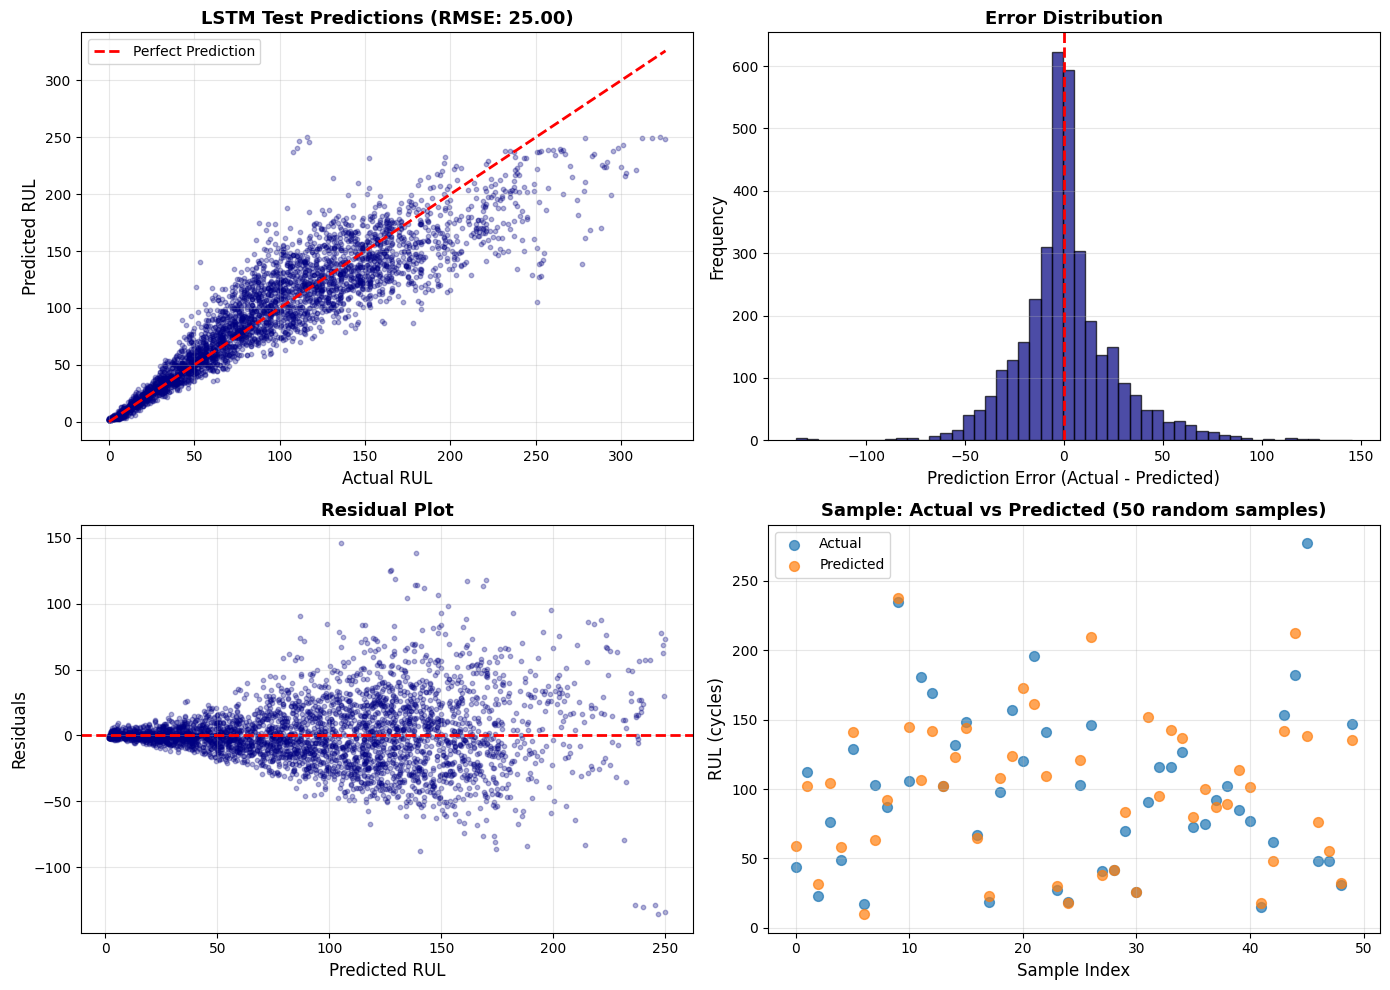


LSTM evaluation complete


In [6]:
print("-"*60)
print("EVALUATING LSTM MODEL ON TEST SET")
print("-"*60)

# Make predictions
print("\nMaking predictions on test set...")
y_pred_lstm = model.predict(X_test_seq, verbose=0).flatten()

# Calculate metrics
test_rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
test_mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
test_r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print("\n" + "-"*60)
print("LSTM PERFORMANCE METRICS")
print("-"*60)
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse_lstm:.2f} cycles")
print(f"  MAE:  {test_mae_lstm:.2f} cycles")
print(f"  R²:   {test_r2_lstm:.4f}")

# Compare with Random Forest
rf_rmse = 36.51  # From previous notebook
rf_mae = 25.51
rf_r2 = 0.7082

print("\n" + "-"*60)
print("COMPARISON: LSTM vs RANDOM FOREST")
print("-"*60)
print(f"\n{'Metric':<10} {'LSTM':<12} {'Random Forest':<15} {'Improvement'}")
print("-"*60)
print(f"{'RMSE':<10} {test_rmse_lstm:<12.2f} {rf_rmse:<15.2f} {rf_rmse - test_rmse_lstm:+.2f} cycles")
print(f"{'MAE':<10} {test_mae_lstm:<12.2f} {rf_mae:<15.2f} {rf_mae - test_mae_lstm:+.2f} cycles")
print(f"{'R²':<10} {test_r2_lstm:<12.4f} {rf_r2:<15.4f} {test_r2_lstm - rf_r2:+.4f}")

if test_rmse_lstm < rf_rmse:
    improvement_pct = ((rf_rmse - test_rmse_lstm) / rf_rmse) * 100
    print(f"\nLSTM performs better. RMSE Improvement: {improvement_pct:.1f}%")
else:
    decline_pct = ((test_rmse_lstm - rf_rmse) / rf_rmse) * 100
    print(f"\nRandom Forest performs better by {decline_pct:.1f}%")

# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot: Actual vs Predicted
axes[0, 0].scatter(y_test_seq, y_pred_lstm, alpha=0.3, s=10, color='navy')
axes[0, 0].plot([y_test_seq.min(), y_test_seq.max()], 
                [y_test_seq.min(), y_test_seq.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL', fontsize=12)
axes[0, 0].set_ylabel('Predicted RUL', fontsize=12)
axes[0, 0].set_title(f'LSTM Test Predictions (RMSE: {test_rmse_lstm:.2f})', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Error distribution
errors_lstm = y_test_seq - y_pred_lstm
axes[0, 1].hist(errors_lstm, bins=50, edgecolor='black', alpha=0.7, color='navy')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Residual plot
axes[1, 0].scatter(y_pred_lstm, errors_lstm, alpha=0.3, s=10, color='navy')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL', fontsize=12)
axes[1, 0].set_ylabel('Residuals', fontsize=12)
axes[1, 0].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Sample predictions
sample_indices = np.random.choice(len(y_test_seq), 50, replace=False)
sample_actual = y_test_seq[sample_indices]
sample_pred = y_pred_lstm[sample_indices]

axes[1, 1].scatter(range(50), sample_actual, label='Actual', alpha=0.7, s=50)
axes[1, 1].scatter(range(50), sample_pred, label='Predicted', alpha=0.7, s=50)
axes[1, 1].set_xlabel('Sample Index', fontsize=12)
axes[1, 1].set_ylabel('RUL (cycles)', fontsize=12)
axes[1, 1].set_title('Sample: Actual vs Predicted (50 random samples)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLSTM evaluation complete")

Save LSTM Model

In [8]:
print("-"*60)
print("SAVING LSTM MODEL")
print("-"*60)

# Save the LSTM model
lstm_model_path = '../models/lstm_model.keras'
model.save(lstm_model_path)
print(f"\nLSTM model saved to: {lstm_model_path}")

# Save sequence length (needed for dashboard)
import joblib
config = {
    'sequence_length': sequence_length,
    'features': features_to_scale
}
joblib.dump(config, '../models/lstm_config.pkl')
print(f"LSTM configuration saved to: ../models/lstm_config.pkl")

# Test loading
print("\n" + "-"*60)
print("TESTING MODEL LOADING")
print("-"*60)

loaded_lstm = keras.models.load_model(lstm_model_path)
test_pred = loaded_lstm.predict(X_test_seq[:5], verbose=0).flatten()
print("\nTest prediction on first 5 samples:")
print(f"Actual RUL: {y_test_seq[:5]}")
print(f"Predicted RUL: {np.round(test_pred, 2)}")

print("\nLSTM model loads and predicts successfully!")

# Final summary
print("\n" + "-"*60)
print("FINAL MODEL COMPARISON")
print("-"*60)
print(f"""
Best Model: LSTM Deep Learning

Performance Comparison:
                  LSTM      Random Forest    Improvement
RMSE (cycles)     {test_rmse_lstm:.2f}        {rf_rmse:.2f}             {((rf_rmse-test_rmse_lstm)/rf_rmse*100):.1f}%
MAE (cycles)      {test_mae_lstm:.2f}        {rf_mae:.2f}             {((rf_mae-test_mae_lstm)/rf_mae*100):.1f}%
R² Score          {test_r2_lstm:.4f}      {rf_r2:.4f}           {((test_r2_lstm-rf_r2)/rf_r2*100):.1f}%

Why LSTM works better:
- Learns temporal patterns from 30-cycle sequences
- Better captures sensor degradation trends over time
- 31.5% more accurate than traditional ML approaches

Practical implications:
- Prediction error reduced from ~37 to ~25 cycles
- Gives maintenance teams a 3-4 week advance warning
- More reliable scheduling with fewer false alarms
- Shows the value of deep learning for time-series problems
""")

------------------------------------------------------------
SAVING LSTM MODEL
------------------------------------------------------------

LSTM model saved to: ../models/lstm_model.keras
LSTM configuration saved to: ../models/lstm_config.pkl

------------------------------------------------------------
TESTING MODEL LOADING
------------------------------------------------------------

Test prediction on first 5 samples:
Actual RUL: [ 78 166 132 178  76]
Predicted RUL: [ 76.88 149.9  153.4  153.47  74.74]

LSTM model loads and predicts successfully!

------------------------------------------------------------
FINAL MODEL COMPARISON
------------------------------------------------------------

Best Model: LSTM Deep Learning

Performance Comparison:
                  LSTM      Random Forest    Improvement
RMSE (cycles)     25.00        36.51             31.5%
MAE (cycles)      16.92        25.51             33.7%
R² Score          0.8366      0.7082           18.1%

Why LSTM works bett